In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

## Preparing the dataset

Here, we will prepare the dataset with the data that we created in chapter three. For an explanation, see the notebook for chapter 3 as well as chapter 3 in the book.

In [6]:
# create batting average dataset (sum over years)
batting = pd.read_csv("~/baseball/core/Batting.csv")
pitching = pd.read_csv("~/baseball/core/Pitching.csv")
# filter pitchers
batting_pitchers = batting.playerID.isin(pitching.playerID)
batting = batting[~batting_pitchers]
# sum over seasons
batting = batting.loc[batting["AB"] > 0].groupby("playerID").agg({"AB": "sum", "H": "sum"})
batting["average"] = batting["H"]/batting["AB"]
# add actual player name
people = pd.read_csv("~/baseball/core/People.csv")
people["name"] = people["nameFirst"] + " " + people["nameLast"]
batting = batting.merge(people[["playerID", "name"]], on="playerID")
# I am using the book values here, not the values that we got in our last notebook. I think the difference comes
# from the fact that we are using more data (data from more recent seasons).
alpha_0 = 101.4
beta_0 = 287.3
# add empirical Bayes estimate
# this is called a point estimate
batting["eb_estimate"] = (batting["H"] + alpha_0) / (batting["AB"] + alpha_0 + beta_0)
batting["alpha_1"] = alpha_0 + batting["H"]
batting["beta_1"] = beta_0 + batting["AB"] - batting["H"]
# sort by eb_estimate
batting = batting.sort_values("eb_estimate", ascending=False)

In [7]:
batting.head()

,playerID,AB,H,average,name,eb_estimate,alpha_1,beta_1
4033,hornsro01,8173,2930,0.358497,Rogers Hornsby,0.354065,3031.4,5530.3
4216,jacksjo01,4981,1772,0.355752,Shoeless Joe Jackson,0.348884,1873.4,3496.3
2159,delahed01,7510,2597,0.345806,Ed Delahanty,0.341626,2698.4,5200.3
3559,hamilbi01,6283,2164,0.344421,Billy Hamilton,0.339554,2265.4,4406.3
4514,keelewi01,8591,2932,0.341287,Willie Keeler,0.337806,3033.4,5946.3


Let's take a look at Mike Piazza and Hank Aaron:

In [77]:
aaron = batting.loc[batting["name"] == "Hank Aaron"]
piazza = batting.loc[batting["name"] == "Mike Piazza"]
matsui = batting.loc[batting["name"] == "Hideki Matsui"]
melton = batting.loc[batting["name"] == "Bill Melton"]

In [10]:
aaron

,playerID,AB,H,average,name,eb_estimate,alpha_1,beta_1
0,aaronha01,12364,3771,0.304998,Hank Aaron,0.303653,3872.4,8880.3


In [11]:
piazza

,playerID,AB,H,average,name,eb_estimate,alpha_1,beta_1
6877,piazzmi01,6911,2127,0.30777,Mike Piazza,0.305273,2228.4,5071.3


In [78]:
melton

,playerID,AB,H,average,name,eb_estimate,alpha_1,beta_1
5807,meltobi01,3971,1004,0.252833,Bill Melton,0.25355,1105.4,3254.3


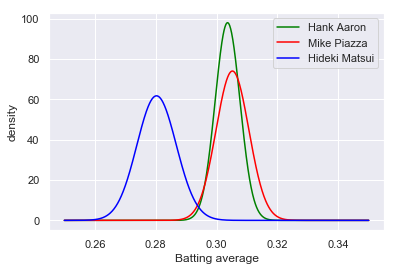

In [14]:
# plot the posterior distributions
x = np.linspace(0.25,0.35,1000)

for data, name, color in [[aaron, "Hank Aaron", "green"], 
                          [piazza, "Mike Piazza", "red"], 
                          [matsui, "Hideki Matsui", "blue"]]:
    alpha = data["alpha_1"]
    beta = data["beta_1"]
    pdf = st.beta.pdf(x,a=alpha,b=beta)
    ax = sns.lineplot(x,pdf, color=color, label=name)
ax.set(xlabel='Batting average', ylabel='density');

Now, if we were to ask, who had a better batting average, Hank Aaron or Mike Piazza, there are multiple possibilities of doing that:

1. Simulation of posterior draws
2. Integration
3. Closed-form solution
4. Closed-form approximation

Let's start with the first. We sample both distributions 1 million times and calculate the ratio that Piazza's draw was larger than Aaron's:

In [75]:
# random draw
alpha_aaron = batting.loc[batting.name=="Hank Aaron", "alpha_1"]
beta_aaron = batting.loc[batting.name=="Hank Aaron", "beta_1"]
aaron_simulation = st.beta.rvs(alpha_aaron, beta_aaron, size=1000000)
alpha_piazza = batting.loc[batting.name=="Mike Piazza", "alpha_1"]
beta_piazza = batting.loc[batting.name=="Mike Piazza", "beta_1"]
piazza_simulation = st.beta.rvs(alpha_piazza, beta_piazza, size=1000000)
alpha_melton = batting.loc[batting.name=="Bill Melton", "alpha_1"]
beta_melton = batting.loc[batting.name=="Bill Melton", "beta_1"]

In [31]:
# compare
comparison = np.where(piazza_simulation > aaron_simulation, 1, 0)
np.mean(comparison)

0.59436

Note that this answer for our hypothesis test is quite different from the frequentist outcome. If we were to use a frequentist hypothesis test, our p-value to reject the null hypothesis probably wouldn't be significant and we wouldn't be able to say anything except "we cannot reject the null hypothesis" and our test would be inconclusive. Here, we can now say that with a probability of 0.594 Piazza had a higher batting average than Aaron.

Now, our next possibility of calculating this is numerical integration:

In [36]:
from scipy.integrate import dblquad
area = dblquad(lambda x, y: st.beta.pdf(x,a=alpha_aaron.values[0],b=beta_aaron.values[0])*st.beta.pdf(y,a=alpha_piazza.values[0],b=beta_piazza.values[0]), 0, 1, lambda x: x, lambda x: 1)

In [39]:
1 - area[0] #since I switched around the order

0.5943243597039876

Next, we can use an approximation: For large alpha and beta, the beta distribution converges to the normal distribution. We are working with decently large numbers, so the approximation is pretty good. We can now calculate the probability that one normal variable is larger than another, which is a very easy calculation:

In [87]:
def credile_interval_approximation(alpha_1, beta_1, alpha_2, beta_2):
    """Calculate the probability 
    
    Parameters
    ----------
    alpha_1: float
        Alpha parameter of the beta posterior distribution of player 1/test A
    beta_1: float
        Beta parameter of the beta posterior distribution of player 1/test A
    alpha_2: float
         Alpha parameter of the beta posterior distribution of player 2/test B 
    beta_2: float
         Beta parameter of the beta posterior distribution of player 2/test B
       
    Returns
    -------
    float
        Probability that test A has a higher probability than B
    float
        Difference in posterior average (mu_2 - mu_1)
    float
        Lower boundary of 95% credible interval
    float
        Upper boundary of 95% credible interval
    """
    mu_1 = alpha_1 / (alpha_1 + beta_1)
    mu_2 = alpha_2 / (alpha_2 + beta_2)
    variance_1 = alpha_1 * beta_1 / ((alpha_1 + beta_1)**2 * (alpha_1 + beta_1 + 1))
    variance_2 = alpha_2 * beta_2 / ((alpha_2 + beta_2)**2 * (alpha_2 + beta_2 + 1))
    mu_diff = mu_2 - mu_1
    sd_diff = np.sqrt(variance_1 + variance_2)
    
    return st.norm(mu_diff, sd_diff).cdf(0), mu_diff, st.norm(mu_diff, sd_diff).ppf(0.025), st.norm(mu_diff, sd_diff).ppf(0.975)

In [53]:
credile_interval_approximation(alpha_piazza.values[0], beta_piazza.values[0], alpha_aaron.values[0], beta_aaron.values[0])

0.00675490900223421


(0.5947371612228725,
 -0.0016194754331937955,
 -0.014858853796418242,
 0.011619902930030648)

In [76]:
credile_interval_approximation(alpha_piazza.values[0], beta_piazza.values[0], alpha_melton.values[0], beta_melton.values[0])

0.008511829366870331


(0.999999999386339,
 -0.05172326326881427,
 -0.06840614227043049,
 -0.03504038426719805)

A normal chi squared hypothesis test yields:

In [82]:
observed = np.array([[1004, 3971], [2127, 6911]])
st.chi2_contingency(observed)

(20.598817323604425,
 5.663108815999413e-06,
 1,
 array([[1111.59102262, 3863.40897738],
        [2019.40897738, 7018.59102262]]))

If we wanted to calculate the confidence interval like R does:

In [89]:
def diffprop(contingency_table):
    """
    Parameters
    ----------
    contingency_table: np.array
        must be a 2x2 numpy array 

    Returns
    -------
    delta: float
        The difference in proportions
    ci: (float, float)
        The Wald 95% confidence interval for delta
    corrected_ci: (float, float)
        Yates continuity correction for the 95% confidence interval of delta.
    """
    n1, n2 = contingency_table[0,1], contingency_table[1,1]
    prop1 = contingency_table[0,0] / n1
    prop2 = contingency_table[1,0] / n2
    delta = prop1 - prop2

    # Wald 95% confidence interval for delta
    se = np.sqrt(prop1*(1 - prop1)/n1 + prop2*(1 - prop2)/n2)
    ci = (delta - 1.96*se, delta + 1.96*se)

    # Yates continuity correction for confidence interval of delta
    correction = 0.5*(1/n1 + 1/n2)
    corrected_ci = (ci[0] - correction, ci[1] + correction)

    return delta, ci, corrected_ci

In [90]:
delta, ci, corrected_ci = diffprop(observed)

In [91]:
delta

-0.05493718184955526

In [92]:
ci

(-0.07229169032276282, -0.0375826733763477)